In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import json
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def load_embedding_data(embedding_dir: str):
    """Load embeddings and associated metadata."""
    embedding_dir = Path(embedding_dir)

    # Load embeddings
    embedding_file = list(embedding_dir.glob("embeddings_*.npy"))[0]
    embeddings = np.load(embedding_file)

    # Load metadata
    metadata_file = list(embedding_dir.glob("metadata_*.json"))[0]
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    # Load token mapping
    token_file = list(embedding_dir.glob("token_mapping_*.csv"))[0]
    token_df = pd.read_csv(token_file)

    print(f"Loaded embeddings: {embeddings.shape}")
    print(f"Model: {metadata['model_name']}")
    print(f"Semantic dimensions: {metadata.get('semantic_dim', 'unknown')}")
    print(f"Label features: {metadata['label_features']}")

    return embeddings, metadata, token_df

In [3]:
def basic_embedding_stats(embeddings: np.ndarray):
    """Compute basic statistics about the embedding space."""
    stats = {
        'shape': embeddings.shape,
        'mean_norm': np.linalg.norm(embeddings, axis=1).mean(),
        'std_norm': np.linalg.norm(embeddings, axis=1).std(),
        'sparsity': (embeddings == 0).sum() / embeddings.size,
        'dimension_variance': embeddings.var(axis=0).mean(),
        'pairwise_similarity_mean': np.corrcoef(embeddings).mean()
    }

    for key, value in stats.items():
        if key == 'shape':
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")

    return stats

In [4]:
def visualize_embedding_space(embeddings: np.ndarray,
                              token_df: pd.DataFrame,
                              cluster_labels: np.ndarray = None,
                              sample_size: int = 1000):
    """Create 2D visualization of embedding space with both t-SNE and PCA."""

    # Sample for visualization if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings_vis = embeddings[indices]
        tokens_vis = token_df.iloc[indices].copy()
        clusters_vis = cluster_labels[indices] if cluster_labels is not None else None
    else:
        embeddings_vis = embeddings
        tokens_vis = token_df.copy()
        clusters_vis = cluster_labels

    # Create both reductions
    print("Computing PCA and t-SNE...")
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(embeddings_vis)

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_vis)-1))
    tsne_coords = tsne.fit_transform(embeddings_vis)

    # Prepare data
    tokens_vis['tsne_x'] = tsne_coords[:, 0]
    tokens_vis['tsne_y'] = tsne_coords[:, 1]
    tokens_vis['pca_x'] = pca_coords[:, 0]
    tokens_vis['pca_y'] = pca_coords[:, 1]
    tokens_vis['text_preview'] = tokens_vis['token'].str[:50]

    if clusters_vis is not None:
        tokens_vis['cluster'] = clusters_vis.astype(str)

    # t-SNE plot
    if clusters_vis is not None:
        fig1 = px.scatter(tokens_vis, x='tsne_x', y='tsne_y', color='cluster',
                          hover_data=['text_preview'],
                          title='t-SNE Embedding Visualization',
                          labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'})
    else:
        fig1 = px.scatter(tokens_vis, x='tsne_x', y='tsne_y',
                          hover_data=['text_preview'],
                          title='t-SNE Embedding Visualization',
                          labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'})

    fig1.update_traces(marker=dict(size=4, opacity=0.7))
    fig1.show()

    # PCA plot
    pca_title = f'PCA Embedding Visualization (explained variance: {pca.explained_variance_ratio_.sum():.2f})'

    if clusters_vis is not None:
        fig2 = px.scatter(tokens_vis, x='pca_x', y='pca_y', color='cluster',
                          hover_data=['text_preview'],
                          title=pca_title,
                          labels={'pca_x': 'PCA 1', 'pca_y': 'PCA 2'})
    else:
        fig2 = px.scatter(tokens_vis, x='pca_x', y='pca_y',
                          hover_data=['text_preview'],
                          title=pca_title,
                          labels={'pca_x': 'PCA 1', 'pca_y': 'PCA 2'})

    fig2.update_traces(marker=dict(size=4, opacity=0.7))
    fig2.show()

    return {'tsne': tsne_coords, 'pca': pca_coords}, tokens_vis

In [5]:
def cluster_analysis(embeddings: np.ndarray,
                     token_df: pd.DataFrame,
                     k_range: range = range(2, 11)):
    """Perform clustering analysis to find natural groupings."""

    silhouette_scores = []
    inertias = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        silhouette_scores.append(silhouette_score(embeddings, labels))
        inertias.append(kmeans.inertia_)

    # Plot elbow curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(k_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Analysis')
    ax1.grid(True)

    ax2.plot(k_range, inertias, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Best k by silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"Best k by silhouette score: {best_k}")

    # Cluster with best k
    kmeans_best = KMeans(n_clusters=best_k, random_state=42)
    cluster_labels = kmeans_best.fit_predict(embeddings)

    # Add clusters to token dataframe
    token_df_clustered = token_df.copy()
    token_df_clustered['cluster'] = cluster_labels

    return cluster_labels, token_df_clustered, best_k

In [6]:
def analyze_semantic_neighbors(embeddings: np.ndarray,
                               token_df: pd.DataFrame,
                               query_tokens: list = None,
                               n_neighbors: int = 5):
    """Find semantically similar tokens."""

    nn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine')
    nn.fit(embeddings)

    if query_tokens is None:
        # Random sample for exploration
        query_indices = np.random.choice(len(embeddings), 3, replace=False)
    else:
        # Find indices of specific tokens
        query_indices = []
        for query in query_tokens:
            matches = token_df[token_df['token'].str.contains(query, case=False)].index
            if len(matches) > 0:
                query_indices.append(matches[0])

    print("=== Semantic Neighbors Analysis ===")
    for idx in query_indices:
        distances, indices = nn.kneighbors([embeddings[idx]])

        print(f"\nQuery: '{token_df.iloc[idx]['token']}'")
        print("Nearest neighbors:")
        for i, (dist, neighbor_idx) in enumerate(zip(distances[0][1:], indices[0][1:])):
            neighbor_token = token_df.iloc[neighbor_idx]['token']
            print(f"  {i+1}. '{neighbor_token}' (distance: {dist:.3f})")

In [7]:
def label_distribution_analysis(embeddings: np.ndarray,
                                token_df: pd.DataFrame,
                                metadata: dict,
                                original_tokens: list):
    """Analyze how labels are distributed in embedding space."""

    if 'feature_names' not in metadata:
        print("No label feature information available")
        return

    # Extract label information from original tokens
    label_data = []
    for token_data in original_tokens:
        labels = token_data['labels']
        row = {'token': token_data['token']}
        for label_type, label_info in labels.items():
            row[f"{label_type}_value"] = label_info['value']
            row[f"{label_type}_confidence"] = label_info['confidence']
        label_data.append(row)

    label_df = pd.DataFrame(label_data)

    # Merge with embeddings
    analysis_df = pd.concat([token_df, label_df.drop('token', axis=1)], axis=1)

    # Analyze label distributions
    print("=== Label Distribution Analysis ===")

    label_types = ['emotions', 'time', 'location', 'characters']
    for label_type in label_types:
        value_col = f"{label_type}_value"
        conf_col = f"{label_type}_confidence"

        if value_col in analysis_df.columns:
            print(f"\n{label_type.title()} Distribution:")
            value_counts = analysis_df[value_col].value_counts()
            print(value_counts.head())

            # High confidence labels
            high_conf = analysis_df[analysis_df[conf_col] > 0.8]
            if len(high_conf) > 0:
                print(f"High confidence ({conf_col} > 0.8): {len(high_conf)} tokens")

    return analysis_df

In [8]:
def generate_analysis_report(embedding_dir: str, original_json: str = None):
    """Generate comprehensive analysis report."""

    print("=== EMBEDDING ANALYSIS REPORT ===\n")

    # Load data
    embeddings, metadata, token_df = load_embedding_data(embedding_dir)

    print("1. BASIC STATISTICS")
    print("-" * 30)
    basic_embedding_stats(embeddings)

    print("\n2. CLUSTERING ANALYSIS")
    print("-" * 30)
    cluster_labels, clustered_df, best_k = cluster_analysis(embeddings, token_df)

    print("\n3. EMBEDDING SPACE VISUALIZATION")
    print("-" * 30)
    coords, vis_df = visualize_embedding_space(embeddings, token_df, cluster_labels)

    print("\n4. SEMANTIC SIMILARITY")
    print("-" * 30)
    analyze_semantic_neighbors(embeddings, token_df)

    if original_json:
        print("\n5. LABEL ANALYSIS")
        print("-" * 30)
        with open(original_json, 'r') as f:
            original_data = json.load(f)
        original_tokens = original_data['tokens'] if 'tokens' in original_data else original_data
        analysis_df = label_distribution_analysis(embeddings, token_df, metadata, original_tokens)

    print("\n=== NEXT STEPS FOR CEBRA ===")
    print("✓ Embeddings are ready for CEBRA auxiliary variables")
    print("✓ Consider the clustering patterns for hypothesis formation")
    print("✓ Label distributions show contextual encoding quality")
    print("✓ Semantic neighbors validate embedding meaningfulness")

    return {
        'embeddings': embeddings,
        'metadata': metadata,
        'token_df': token_df,
        'clusters': cluster_labels,
        'coords': coords
    }

In [9]:
def quick_embedding_check(embedding_dir: str):
    """Fast quality check of your embeddings."""
    embeddings, metadata, token_df = load_embedding_data(embedding_dir)

    print("🔍 QUICK EMBEDDING CHECK")
    print("=" * 25)

    # Basic stats
    print(f"✓ Shape: {embeddings.shape}")
    print(f"✓ Model: {metadata.get('model_name', 'unknown')}")
    print(f"✓ Mean embedding norm: {np.linalg.norm(embeddings, axis=1).mean():.3f}")

    # Sample some tokens
    print("\n📝 Sample tokens:")
    sample_indices = np.random.choice(len(token_df), min(5, len(token_df)), replace=False)
    for idx in sample_indices:
        print(f"  '{token_df.iloc[idx]['token']}'")

    # Quick visualization
    print("\n📊 Generating visualization...")
    coords, vis_df = visualize_embedding_space(embeddings, token_df, sample_size=500)

    print("\n✅ Embeddings look good! Ready for CEBRA analysis.")

    return embeddings, token_df

In [24]:
quick_embedding_check("./embeddings_output/v0/performance")

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
🔍 QUICK EMBEDDING CHECK
✓ Shape: (1182, 1032)
✓ Model: BAAI/bge-large-en-v1.5
✓ Mean embedding norm: 1.743

📝 Sample tokens:
  'had her drink plenty'
  'that day.'
  'it was November,'
  'through the town'
  'were two mattresses'

📊 Generating visualization...
Computing PCA and t-SNE...



✅ Embeddings look good! Ready for CEBRA analysis.


(array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.29533458,  0.39266074],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.29533458,  0.39266074],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.34225484, -1.10969339],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.02525892,  0.00426366, -0.08279312, ...,  0.        ,
          0.        ,  0.        ]], shape=(1182, 1032)),
       index                      token  \
 0         0             The email came   
 1         1         late one afternoon   
 2         2                     as Dr.   
 3         3    Carmen Reed was sitting   
 4         4              in her office   
 ...     ...                        ...   
 1177   1177                    and she   
 1178   1

=== EMBEDDING ANALYSIS REPORT ===

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
1. BASIC STATISTICS
------------------------------
shape: (1182, 1032)
mean_norm: 1.7433
std_norm: 0.6008
sparsity: 0.0054
dimension_variance: 0.0028
pairwise_similarity_mean: 0.2114

2. CLUSTERING ANALYSIS
------------------------------


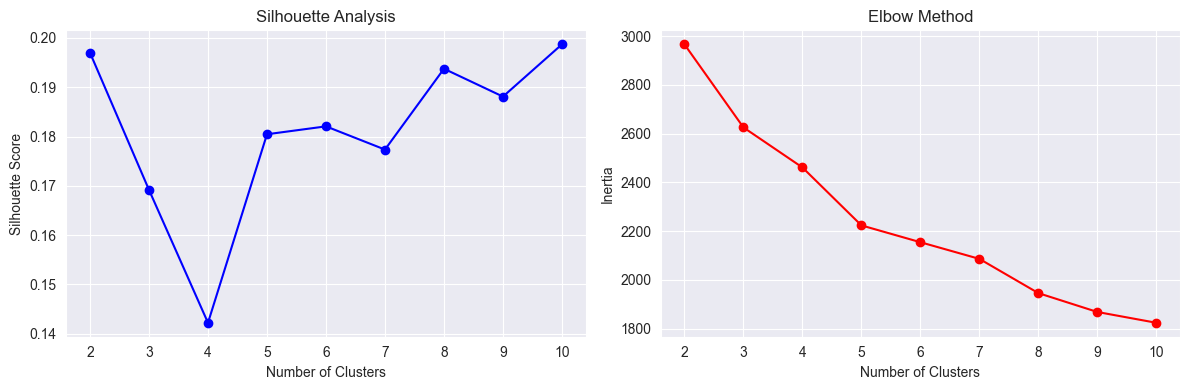

Best k by silhouette score: 10

3. EMBEDDING SPACE VISUALIZATION
------------------------------
Computing PCA and t-SNE...



4. SEMANTIC SIMILARITY
------------------------------
=== Semantic Neighbors Analysis ===

Query: 'You must be very'
Nearest neighbors:
  1. 'the patient with the strange' (distance: 0.085)
  2. 'expression on his face.' (distance: 0.093)
  3. 'the men suddenly' (distance: 0.101)
  4. 'could be risking her life' (distance: 0.124)
  5. 'a broom made' (distance: 0.125)

Query: 'stay in the clinic overnight'
Nearest neighbors:
  1. 'they emerged into' (distance: 0.185)
  2. 'in the clinic,' (distance: 0.226)
  3. 'The clinic' (distance: 0.239)
  4. 'the busy clinic in' (distance: 0.242)
  5. 'left the clinic,' (distance: 0.243)

Query: 'Inside'
Nearest neighbors:
  1. 'over in her hands,' (distance: 0.093)
  2. 'unsettled,' (distance: 0.095)
  3. 'in her thoughts,' (distance: 0.097)
  4. 'handmade necklace.' (distance: 0.110)
  5. 'and Carmen was touched.' (distance: 0.114)

=== NEXT STEPS FOR CEBRA ===
✓ Embeddings are ready for CEBRA auxiliary variables
✓ Consider the clustering patter

{'embeddings': array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.29533458,  0.39266074],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.29533458,  0.39266074],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.34225484, -1.10969339],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.02525892,  0.00426366, -0.08279312, ...,  0.        ,
          0.        ,  0.        ]], shape=(1182, 1032)),
 'metadata': {'model_tier': 'performance',
  'model_name': 'BAAI/bge-large-en-v1.5',
  'embedding_dim': 1032,
  'label_features': 8,
  'num_tokens': 1182,
  'feature_names': ['characters_value',
   'characters_confidence',
   'emotions_value',
   'emotions_confidence',
   'location_value',
   'location_confidence',
   'time_value',
   't

In [25]:
generate_analysis_report("./embeddings_output/v0/performance")

In [18]:
quick_embedding_check("./embeddings_output/v1/performance")

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
🔍 QUICK EMBEDDING CHECK
✓ Shape: (1182, 1032)
✓ Model: BAAI/bge-large-en-v1.5
✓ Mean embedding norm: 2.095

📝 Sample tokens:
  'was threatening to'
  'but to accept it.'
  'the patients she'
  'Dr. Carmen, good'
  'onto a side street'

📊 Generating visualization...
Computing PCA and t-SNE...



✅ Embeddings look good! Ready for CEBRA analysis.


(array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.38730452,  0.51504293],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.34799839,  1.33077567],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.50522288, -1.93215528],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.23978489,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ..., -0.62373048,
          0.        ,  0.        ],
        [-0.02525892,  0.00426366, -0.08279312, ...,  0.        ,
          0.        ,  0.        ]], shape=(1182, 1032)),
       index                      token  \
 0         0             The email came   
 1         1         late one afternoon   
 2         2                     as Dr.   
 3         3    Carmen Reed was sitting   
 4         4              in her office   
 ...     ...                        ...   
 1177   1177                    and she   
 1178   1

=== EMBEDDING ANALYSIS REPORT ===

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
1. BASIC STATISTICS
------------------------------
shape: (1182, 1032)
mean_norm: 2.0947
std_norm: 0.6632
sparsity: 0.0040
dimension_variance: 0.0042
pairwise_similarity_mean: 0.1440

2. CLUSTERING ANALYSIS
------------------------------


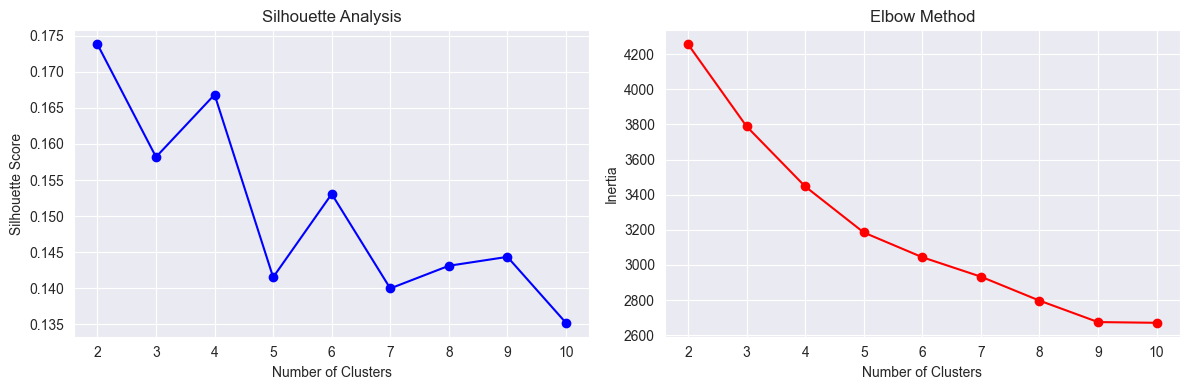

Best k by silhouette score: 2

3. EMBEDDING SPACE VISUALIZATION
------------------------------
Computing PCA and t-SNE...



4. SEMANTIC SIMILARITY
------------------------------
=== Semantic Neighbors Analysis ===

Query: 'rash across'
Nearest neighbors:
  1. 'sick?' (distance: 0.115)
  2. 'got worse.' (distance: 0.128)
  3. 'expression on his face.' (distance: 0.132)
  4. 'gasped, and' (distance: 0.141)
  5. 'eyes.' (distance: 0.141)

Query: 'the clinic,'
Nearest neighbors:
  1. 'behind her hut,' (distance: 0.134)
  2. 'clinic to retrieve' (distance: 0.180)
  3. 'of her hut.' (distance: 0.211)
  4. 'patient came to the clinic' (distance: 0.212)
  5. 'The clinic' (distance: 0.238)

Query: 'and Carmen'
Nearest neighbors:
  1. 'and Carmen' (distance: 0.000)
  2. 'But then Carmen' (distance: 0.062)
  3. 'Carmen' (distance: 0.064)
  4. 'Carmen' (distance: 0.064)
  5. 'Carmen' (distance: 0.064)

=== NEXT STEPS FOR CEBRA ===
✓ Embeddings are ready for CEBRA auxiliary variables
✓ Consider the clustering patterns for hypothesis formation
✓ Label distributions show contextual encoding quality
✓ Semantic neighbors v

{'embeddings': array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.38730452,  0.51504293],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.34799839,  1.33077567],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.50522288, -1.93215528],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.23978489,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ..., -0.62373048,
          0.        ,  0.        ],
        [-0.02525892,  0.00426366, -0.08279312, ...,  0.        ,
          0.        ,  0.        ]], shape=(1182, 1032)),
 'metadata': {'model_tier': 'performance',
  'model_name': 'BAAI/bge-large-en-v1.5',
  'embedding_dim': 1032,
  'label_features': 8,
  'num_tokens': 1182,
  'feature_names': ['characters_value',
   'characters_confidence',
   'emotions_value',
   'emotions_confidence',
   'location_value',
   'location_confidence',
   'time_value',
   't

In [21]:
generate_analysis_report("./embeddings_output/v1/performance")

In [ ]:
# Sample tokens from each cluster to understand the themes
cluster_0_samples = token_df[cluster_labels == 0]['token'].sample(20)
cluster_1_samples = token_df[cluster_labels == 1]['token'].sample(20)

print("CLUSTER 0 samples:")
for token in cluster_0_samples:
    print(f"  '{token}'")

print("\nCLUSTER 1 samples:")
for token in cluster_1_samples:
    print(f"  '{token}'")

In [22]:
quick_embedding_check("./embeddings_output/v2/performance")

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
🔍 QUICK EMBEDDING CHECK
✓ Shape: (1182, 1032)
✓ Model: BAAI/bge-large-en-v1.5
✓ Mean embedding norm: 2.302

📝 Sample tokens:
  'recognized the man'
  'she left now, the'
  'doctor'
  'Carmen, but'
  'her walk to the clinic,'

📊 Generating visualization...
Computing PCA and t-SNE...



✅ Embeddings look good! Ready for CEBRA analysis.


(array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.43736426,  0.82491015],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.38165835,  1.646347  ],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.5487761 , -0.81796354],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.43644437,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ..., -0.44674056,
          0.72659635,  0.00347331],
        [-0.02525892,  0.00426366, -0.08279312, ..., -0.44674056,
          0.        ,  0.        ]], shape=(1182, 1032)),
       index                      token  \
 0         0             The email came   
 1         1         late one afternoon   
 2         2                     as Dr.   
 3         3    Carmen Reed was sitting   
 4         4              in her office   
 ...     ...                        ...   
 1177   1177                    and she   
 1178   1

=== EMBEDDING ANALYSIS REPORT ===

Loaded embeddings: (1182, 1032)
Model: BAAI/bge-large-en-v1.5
Semantic dimensions: unknown
Label features: 8
1. BASIC STATISTICS
------------------------------
shape: (1182, 1032)
mean_norm: 2.3019
std_norm: 0.7060
sparsity: 0.0031
dimension_variance: 0.0051
pairwise_similarity_mean: 0.1178

2. CLUSTERING ANALYSIS
------------------------------


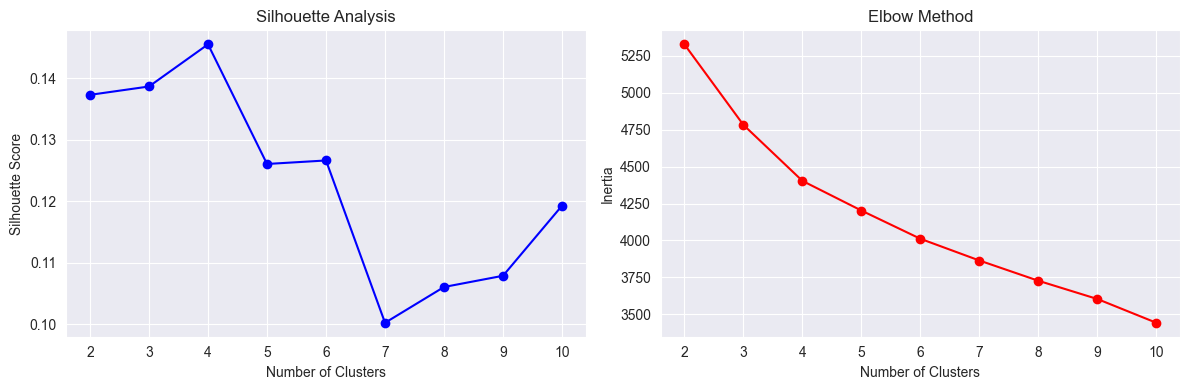

Best k by silhouette score: 4

3. EMBEDDING SPACE VISUALIZATION
------------------------------
Computing PCA and t-SNE...



4. SEMANTIC SIMILARITY
------------------------------
=== Semantic Neighbors Analysis ===

Query: 'pieces of simple'
Nearest neighbors:
  1. 'table.' (distance: 0.151)
  2. 'bed' (distance: 0.160)
  3. 'of Spanish' (distance: 0.203)
  4. 'Spanish.' (distance: 0.217)
  5. 'had come from another' (distance: 0.227)

Query: 'Juan promised'
Nearest neighbors:
  1. 'Juan her list' (distance: 0.111)
  2. 'treating him with medication,' (distance: 0.134)
  3. 'fever.' (distance: 0.147)
  4. 'hit by a wave' (distance: 0.150)
  5. 'with Carmen slow' (distance: 0.165)

Query: 'heard footsteps'
Nearest neighbors:
  1. 'but dense shadowy' (distance: 0.037)
  2. 'behind her hut,' (distance: 0.098)
  3. 'to panic, she' (distance: 0.127)
  4. 'the clinic,' (distance: 0.128)
  5. 'the villagers  were not telling' (distance: 0.168)

=== NEXT STEPS FOR CEBRA ===
✓ Embeddings are ready for CEBRA auxiliary variables
✓ Consider the clustering patterns for hypothesis formation
✓ Label distributions show con

{'embeddings': array([[-0.01753593, -0.0254418 , -0.00627169, ...,  0.        ,
         -1.43736426,  0.82491015],
        [-0.01281816,  0.00543275, -0.03477811, ...,  0.        ,
         -1.38165835,  1.646347  ],
        [ 0.00490915, -0.02638982, -0.00268276, ...,  0.        ,
         -1.5487761 , -0.81796354],
        ...,
        [ 0.01586347, -0.02783647, -0.02138238, ...,  0.43644437,
          0.        ,  0.        ],
        [ 0.04335512, -0.02744186, -0.0249155 , ..., -0.44674056,
          0.72659635,  0.00347331],
        [-0.02525892,  0.00426366, -0.08279312, ..., -0.44674056,
          0.        ,  0.        ]], shape=(1182, 1032)),
 'metadata': {'model_tier': 'performance',
  'model_name': 'BAAI/bge-large-en-v1.5',
  'embedding_dim': 1032,
  'label_features': 8,
  'num_tokens': 1182,
  'feature_names': ['characters_value',
   'characters_confidence',
   'emotions_value',
   'emotions_confidence',
   'location_value',
   'location_confidence',
   'time_value',
   't

In [23]:
generate_analysis_report("./embeddings_output/v2/performance")

# Entropy

In [28]:
#!/usr/bin/env python3
"""
Label Entropy Analysis for Multiple Labeling Attempts - Notebook Version
Analyzes consistency and uncertainty across multiple JSON label files
"""

import json
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import argparse

class LabelEntropyAnalyzer:
    def __init__(self):
        self.categories = ['location', 'characters', 'emotions', 'time']
        self.token_data = defaultdict(lambda: defaultdict(list))  # token_index -> category -> [values]
        self.file_count = 0

    def load_json_files(self, file_paths: List[str]) -> None:
        """Load multiple JSON files and organize data by token index"""
        print(f"Loading {len(file_paths)} JSON files...")

        for i, file_path in enumerate(file_paths):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                tokens = data.get('tokens', [])
                print(f"File {i+1}: {len(tokens)} tokens loaded from {Path(file_path).name}")

                for token_entry in tokens:
                    token_idx = token_entry['index']
                    labels = token_entry['labels']

                    for category in self.categories:
                        if category in labels:
                            value = labels[category]['value']
                            self.token_data[token_idx][category].append(value)

                self.file_count += 1

            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue

        print(f"Successfully loaded {self.file_count} files")
        print(f"Token range: {min(self.token_data.keys())} to {max(self.token_data.keys())}")

    def calculate_entropy(self, values: List[str]) -> float:
        """Calculate Shannon entropy for a list of values"""
        if not values:
            return 0.0

        # Count occurrences of each value
        value_counts = Counter(values)
        total = len(values)

        # Calculate entropy
        entropy = 0.0
        for count in value_counts.values():
            probability = count / total
            if probability > 0:
                entropy -= probability * np.log2(probability)

        return entropy

    def analyze_entropy_per_token(self) -> pd.DataFrame:
        """Calculate entropy for each token and category"""
        results = []

        print("Calculating entropy per token...")

        for token_idx in sorted(self.token_data.keys()):
            token_result = {
                'token_index': token_idx,
                'total_entropy': 0.0
            }

            for category in self.categories:
                values = self.token_data[token_idx][category]

                # Pad with 'null' if not all files provided a label
                while len(values) < self.file_count:
                    values.append('null')

                entropy = self.calculate_entropy(values)
                token_result[f'{category}_entropy'] = entropy
                token_result[f'{category}_unique_labels'] = len(set(values))
                token_result[f'{category}_values'] = values.copy()

                # Add to total entropy
                token_result['total_entropy'] += entropy

            # Calculate average entropy across categories
            token_result['avg_entropy'] = token_result['total_entropy'] / len(self.categories)

            results.append(token_result)

        return pd.DataFrame(results)

    def get_high_uncertainty_tokens(self, df: pd.DataFrame, threshold_percentile: int = 90) -> pd.DataFrame:
        """Identify tokens with high uncertainty (high entropy)"""
        # Calculate threshold for each category
        high_uncertainty = df.copy()

        for category in self.categories:
            col = f'{category}_entropy'
            threshold = np.percentile(df[col], threshold_percentile)
            high_uncertainty[f'{category}_high_uncertainty'] = df[col] >= threshold

        # Tokens with high uncertainty in any category
        uncertainty_cols = [f'{category}_high_uncertainty' for category in self.categories]
        high_uncertainty['any_high_uncertainty'] = high_uncertainty[uncertainty_cols].any(axis=1)

        # Sort by total entropy
        high_uncertainty = high_uncertainty.sort_values('total_entropy', ascending=False)

        return high_uncertainty

    def plot_entropy_distribution(self, df: pd.DataFrame, save_path: str = None) -> None:
        """Plot entropy distributions for each category"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        # Plot each category
        for i, category in enumerate(self.categories):
            col = f'{category}_entropy'
            axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{category.capitalize()} Entropy Distribution')
            axes[i].set_xlabel('Entropy')
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)

        # Plot total entropy
        axes[4].hist(df['total_entropy'], bins=30, alpha=0.7, edgecolor='black', color='red')
        axes[4].set_title('Total Entropy Distribution')
        axes[4].set_xlabel('Total Entropy')
        axes[4].set_ylabel('Frequency')
        axes[4].grid(True, alpha=0.3)

        # Plot average entropy
        axes[5].hist(df['avg_entropy'], bins=30, alpha=0.7, edgecolor='black', color='purple')
        axes[5].set_title('Average Entropy Distribution')
        axes[5].set_xlabel('Average Entropy')
        axes[5].set_ylabel('Frequency')
        axes[5].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Entropy distribution plot saved to {save_path}")

        plt.show()

    def plot_entropy_timeline(self, df: pd.DataFrame, save_path: str = None) -> None:
        """Plot entropy over token position (story timeline)"""
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Plot individual categories
        for category in self.categories:
            col = f'{category}_entropy'
            axes[0].plot(df['token_index'], df[col], label=category.capitalize(), alpha=0.7)

        axes[0].set_title('Label Entropy Over Story Timeline (by Category)')
        axes[0].set_xlabel('Token Index')
        axes[0].set_ylabel('Entropy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot total entropy
        axes[1].plot(df['token_index'], df['total_entropy'], color='red', linewidth=2)
        axes[1].set_title('Total Label Entropy Over Story Timeline')
        axes[1].set_xlabel('Token Index')
        axes[1].set_ylabel('Total Entropy')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Entropy timeline plot saved to {save_path}")

        plt.show()

    def save_results(self, df: pd.DataFrame, output_path: str) -> None:
        """Save results to CSV"""
        # Create a clean version for CSV (remove the list columns)
        df_clean = df.copy()

        # Remove the values columns which contain lists
        value_cols = [f'{category}_values' for category in self.categories]
        df_clean = df_clean.drop(columns=value_cols)

        df_clean.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")

    def print_summary_statistics(self, df: pd.DataFrame) -> None:
        """Print summary statistics"""
        print("\n" + "="*50)
        print("LABEL ENTROPY ANALYSIS SUMMARY")
        print("="*50)
        print(f"Total tokens analyzed: {len(df)}")
        print(f"Number of labeling attempts: {self.file_count}")

        print(f"\nEntropy Statistics by Category:")
        for category in self.categories:
            col = f'{category}_entropy'
            mean_entropy = df[col].mean()
            max_entropy = df[col].max()
            std_entropy = df[col].std()
            print(f"  {category.capitalize():12}: mean={mean_entropy:.3f}, max={max_entropy:.3f}, std={std_entropy:.3f}")

        print(f"\nOverall Entropy:")
        print(f"  Total entropy:   mean={df['total_entropy'].mean():.3f}, max={df['total_entropy'].max():.3f}")
        print(f"  Average entropy: mean={df['avg_entropy'].mean():.3f}, max={df['avg_entropy'].max():.3f}")

        # High uncertainty tokens (top 10%)
        high_uncertainty = df.nlargest(int(len(df) * 0.1), 'total_entropy')
        print(f"\nTop 10% most uncertain tokens (by total entropy):")
        print(f"  Token indices: {high_uncertainty['token_index'].tolist()}")
        print(f"  Entropy range: {high_uncertainty['total_entropy'].min():.3f} - {high_uncertainty['total_entropy'].max():.3f}")


# =============================================================================
# NOTEBOOK USAGE EXAMPLE
# =============================================================================

def analyze_label_entropy(json_files, output_csv=None, plot_distribution=True,
                          plot_timeline=True, save_plots=False, plot_dir="./"):
    """
    Complete label entropy analysis workflow for notebook use.

    Args:
        json_files (list): List of paths to JSON files from token labeling
        output_csv (str, optional): Path to save CSV results
        plot_distribution (bool): Whether to show entropy distribution plots
        plot_timeline (bool): Whether to show entropy timeline plot
        save_plots (bool): Whether to save plots to files
        plot_dir (str): Directory to save plots if save_plots=True

    Returns:
        pd.DataFrame: Results dataframe with entropy analysis

    Example usage in notebook:
        # Basic analysis
        json_files = ['labels1.json', 'labels2.json', 'labels3.json']
        results = analyze_label_entropy(json_files)

        # With file outputs
        results = analyze_label_entropy(
            json_files,
            output_csv='entropy_results.csv',
            save_plots=True,
            plot_dir='./plots/'
        )

        # Access high uncertainty tokens
        high_uncertainty = results.nlargest(20, 'total_entropy')
        print(high_uncertainty[['token_index', 'total_entropy', 'location_entropy']])
    """
    # Initialize analyzer
    analyzer = LabelEntropyAnalyzer()

    # Load JSON files
    analyzer.load_json_files(json_files)

    # Analyze entropy
    results_df = analyzer.analyze_entropy_per_token()

    # Print summary
    analyzer.print_summary_statistics(results_df)

    # Save results if requested
    if output_csv:
        analyzer.save_results(results_df, output_csv)

    # Generate plots
    if plot_distribution:
        save_path = f"{plot_dir}/entropy_distribution.png" if save_plots else None
        analyzer.plot_entropy_distribution(results_df, save_path)

    if plot_timeline:
        save_path = f"{plot_dir}/entropy_timeline.png" if save_plots else None
        analyzer.plot_entropy_timeline(results_df, save_path)

    return results_df


# =============================================================================
# QUICK START EXAMPLES FOR NOTEBOOK
# =============================================================================

"""
# Example 1: Basic entropy analysis
json_files = ['labels_run1.json', 'labels_run2.json', 'labels_run3.json']
results = analyze_label_entropy(json_files)

# Example 2: Find most uncertain tokens
high_uncertainty = results.nlargest(10, 'total_entropy')
print("Most uncertain tokens:")
print(high_uncertainty[['token_index', 'total_entropy', 'avg_entropy']])

# Example 3: Category-specific analysis
emotion_uncertainty = results.nlargest(10, 'emotions_entropy')
character_uncertainty = results.nlargest(10, 'characters_entropy')

# Example 4: Advanced usage with custom analysis
analyzer = LabelEntropyAnalyzer()
analyzer.load_json_files(json_files)
results = analyzer.analyze_entropy_per_token()

# Custom threshold analysis
high_uncertainty_90th = analyzer.get_high_uncertainty_tokens(results, threshold_percentile=90)
any_uncertain = high_uncertainty_90th[high_uncertainty_90th['any_high_uncertainty']]

# Save specific results
analyzer.save_results(results, 'detailed_entropy_analysis.csv')
"""

'\n# Example 1: Basic entropy analysis\njson_files = [\'labels_run1.json\', \'labels_run2.json\', \'labels_run3.json\']\nresults = analyze_label_entropy(json_files)\n\n# Example 2: Find most uncertain tokens\nhigh_uncertainty = results.nlargest(10, \'total_entropy\')\nprint("Most uncertain tokens:")\nprint(high_uncertainty[[\'token_index\', \'total_entropy\', \'avg_entropy\']])\n\n# Example 3: Category-specific analysis\nemotion_uncertainty = results.nlargest(10, \'emotions_entropy\')\ncharacter_uncertainty = results.nlargest(10, \'characters_entropy\')\n\n# Example 4: Advanced usage with custom analysis\nanalyzer = LabelEntropyAnalyzer()\nanalyzer.load_json_files(json_files)\nresults = analyzer.analyze_entropy_per_token()\n\n# Custom threshold analysis\nhigh_uncertainty_90th = analyzer.get_high_uncertainty_tokens(results, threshold_percentile=90)\nany_uncertain = high_uncertainty_90th[high_uncertainty_90th[\'any_high_uncertainty\']]\n\n# Save specific results\nanalyzer.save_results(re

Loading 4 JSON files...
File 1: 1182 tokens loaded from output.json
File 2: 1182 tokens loaded from output1_processed_first.json
File 3: 1182 tokens loaded from output2_processed_first.json
File 4: 1182 tokens loaded from full_story_output.json
Successfully loaded 4 files
Token range: 0 to 1181
Calculating entropy per token...

LABEL ENTROPY ANALYSIS SUMMARY
Total tokens analyzed: 1182
Number of labeling attempts: 4

Entropy Statistics by Category:
  Location    : mean=1.083, max=2.000, std=0.500
  Characters  : mean=1.199, max=2.000, std=0.462
  Emotions    : mean=1.117, max=2.000, std=0.577
  Time        : mean=0.994, max=2.000, std=0.571

Overall Entropy:
  Total entropy:   mean=4.393, max=7.500
  Average entropy: mean=1.098, max=1.875

Top 10% most uncertain tokens (by total entropy):
  Token indices: [62, 230, 340, 574, 947, 1116, 211, 217, 228, 336, 477, 754, 840, 897, 924, 1019, 779, 39, 44, 46, 143, 232, 288, 315, 318, 361, 377, 383, 407, 409, 431, 438, 500, 536, 557, 562, 563,

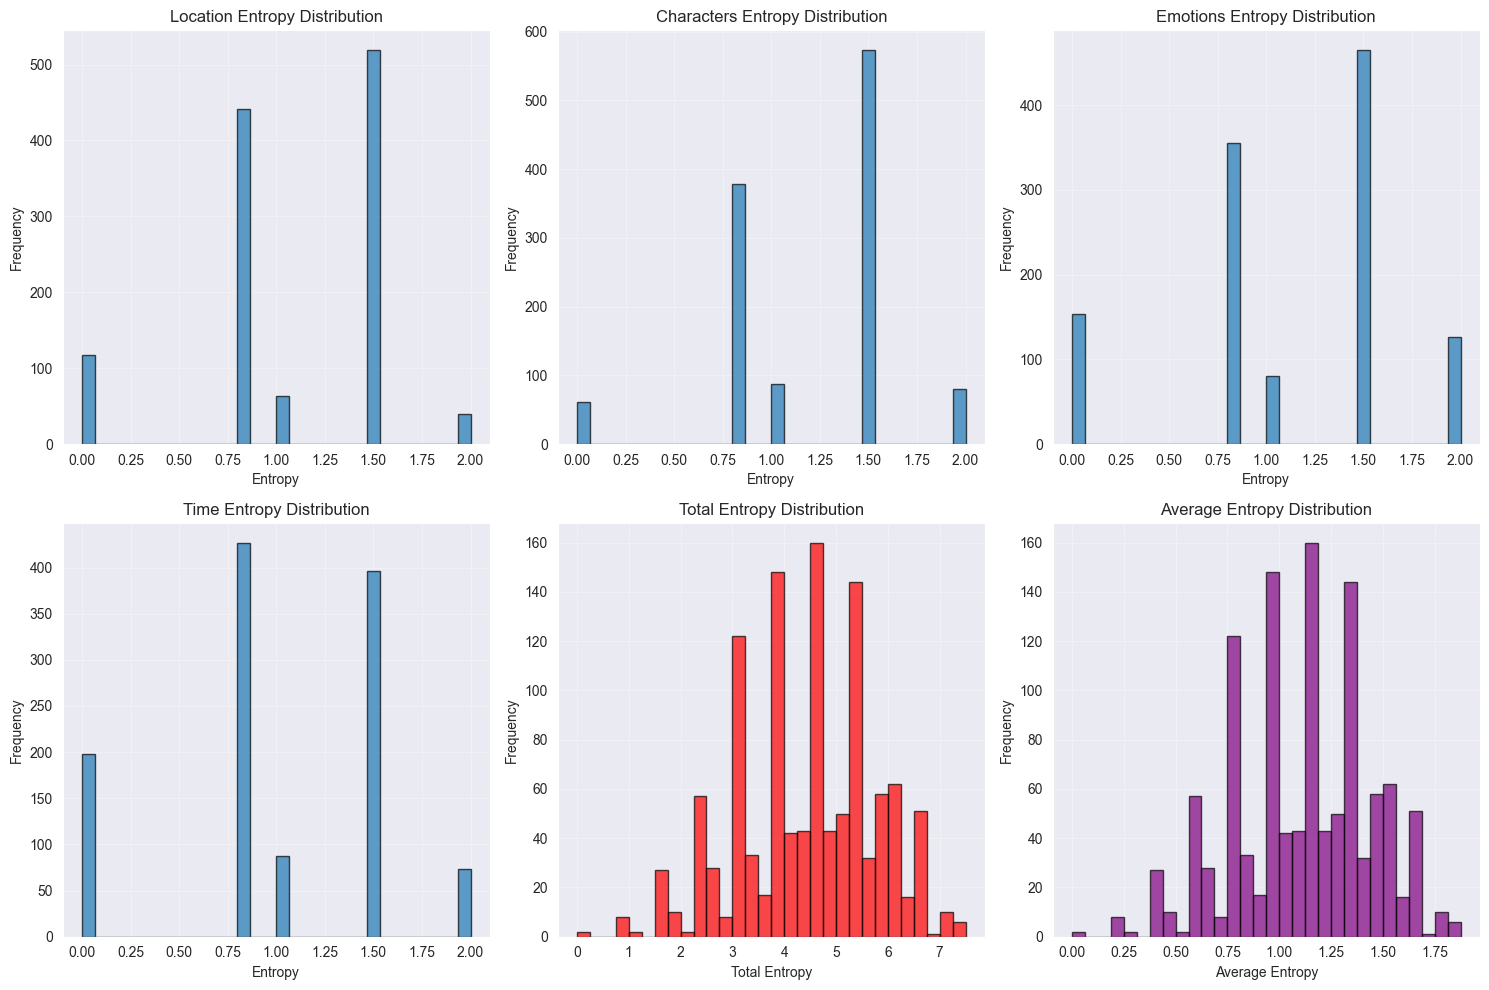

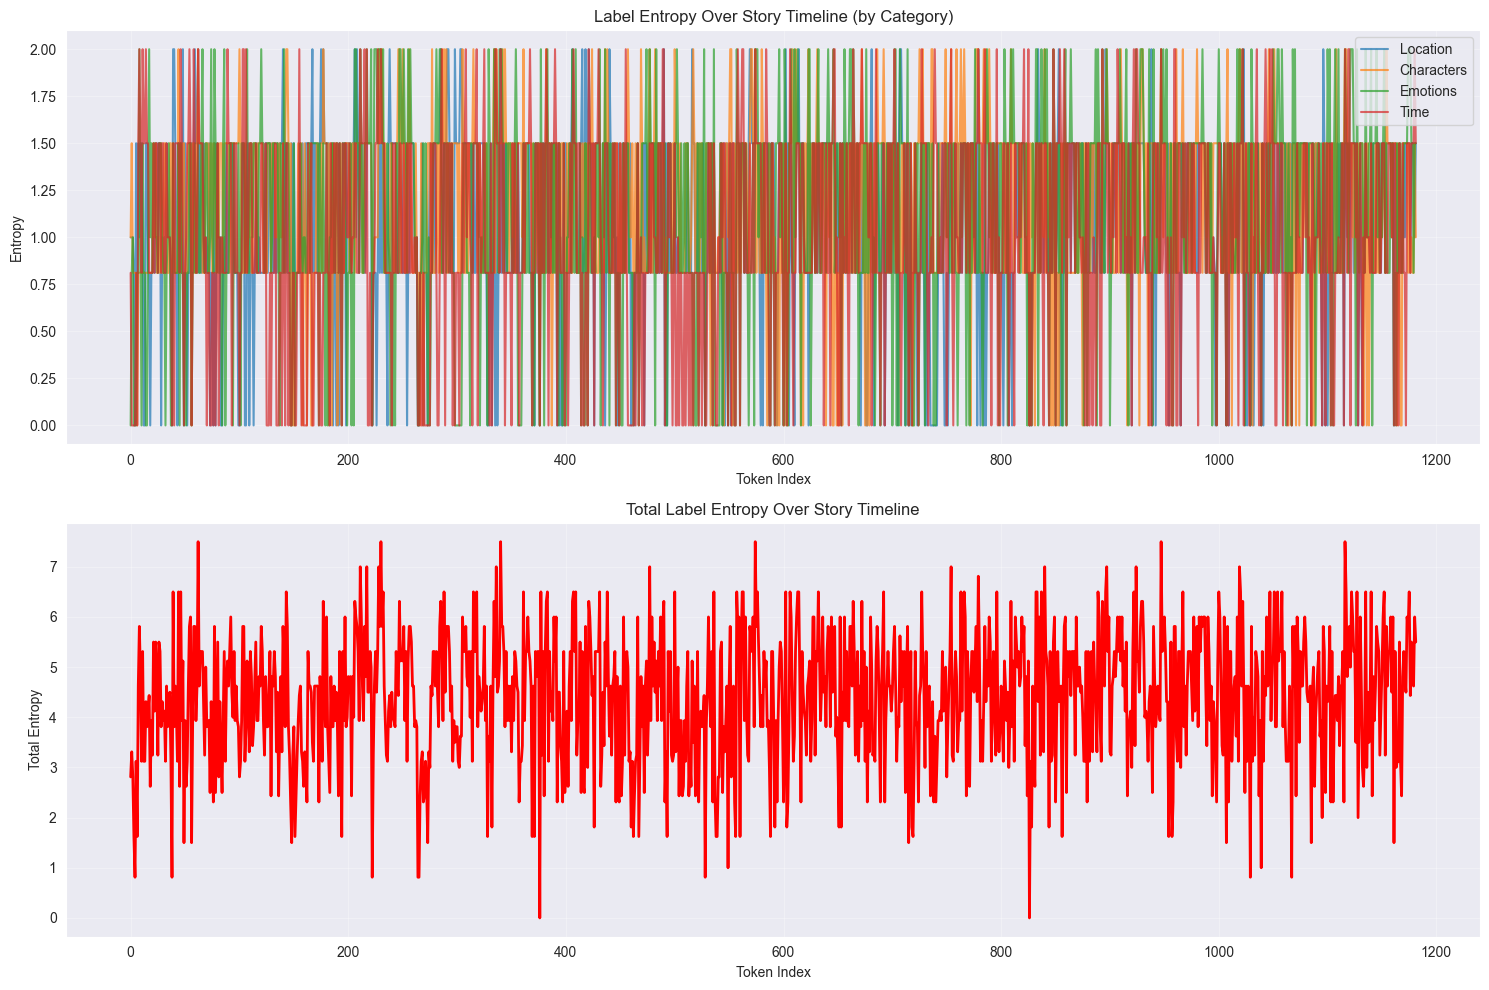

In [30]:
json_files = ["output.json", "output1_processed_first.json", "output2_processed_first.json", "full_story_output.json"]
results = analyze_label_entropy(json_files)


# Matrix

In [29]:
#!/usr/bin/env python3
"""
Pairwise Distance Matrix Calculator for Token Embeddings - Notebook Version
Computes distance matrices using different metrics and provides visualizations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy.spatial.distance import pdist, squareform
from pathlib import Path
from typing import Union, Tuple
import warnings

class EmbeddingDistanceAnalyzer:
    def __init__(self):
        self.embeddings = None
        self.distance_matrix = None
        self.distance_metric = None
        self.n_tokens = 0

    def load_embeddings(self, embedding_path: str) -> None:
        """Load embeddings from numpy file"""
        try:
            self.embeddings = np.load(embedding_path)
            self.n_tokens = self.embeddings.shape[0]
            print(f"Loaded embeddings: {self.embeddings.shape}")
            print(f"Number of tokens: {self.n_tokens}")
            print(f"Embedding dimension: {self.embeddings.shape[1]}")
        except Exception as e:
            raise ValueError(f"Error loading embeddings from {embedding_path}: {e}")

    def calculate_distance_matrix(self, metric: str = 'euclidean') -> np.ndarray:
        """
        Calculate pairwise distance matrix

        Args:
            metric: 'euclidean' or 'cosine'

        Returns:
            Distance matrix of shape (n_tokens, n_tokens)
        """
        if self.embeddings is None:
            raise ValueError("Embeddings not loaded. Call load_embeddings() first.")

        print(f"Calculating {metric} distance matrix...")

        if metric.lower() == 'euclidean':
            # Use sklearn for efficiency
            self.distance_matrix = euclidean_distances(self.embeddings)
            self.distance_metric = 'euclidean'

        elif metric.lower() == 'cosine':
            # Use sklearn cosine distances
            self.distance_matrix = cosine_distances(self.embeddings)
            self.distance_metric = 'cosine'

        else:
            raise ValueError(f"Unsupported metric: {metric}. Use 'euclidean' or 'cosine'")

        print(f"Distance matrix shape: {self.distance_matrix.shape}")
        print(f"Distance range: {self.distance_matrix.min():.6f} to {self.distance_matrix.max():.6f}")

        return self.distance_matrix

    def get_distance_statistics(self) -> dict:
        """Get descriptive statistics of the distance matrix"""
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated. Call calculate_distance_matrix() first.")

        # Get upper triangle (excluding diagonal) for statistics
        upper_triangle = np.triu(self.distance_matrix, k=1)
        distances = upper_triangle[upper_triangle > 0]  # Only non-zero values

        stats = {
            'metric': self.distance_metric,
            'mean_distance': np.mean(distances),
            'median_distance': np.median(distances),
            'std_distance': np.std(distances),
            'min_distance': np.min(distances),
            'max_distance': np.max(distances),
            'q25': np.percentile(distances, 25),
            'q75': np.percentile(distances, 75)
        }

        return stats

    def find_most_similar_pairs(self, n_pairs: int = 10) -> pd.DataFrame:
        """Find the most similar token pairs (smallest distances)"""
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        # Get upper triangle indices (avoid duplicates and self-distances)
        triu_indices = np.triu_indices(self.n_tokens, k=1)
        distances = self.distance_matrix[triu_indices]

        # Get indices of smallest distances
        smallest_indices = np.argsort(distances)[:n_pairs]

        results = []
        for idx in smallest_indices:
            i, j = triu_indices[0][idx], triu_indices[1][idx]
            distance = distances[idx]
            results.append({
                'token_1': i,
                'token_2': j,
                'distance': distance
            })

        return pd.DataFrame(results)

    def find_most_different_pairs(self, n_pairs: int = 10) -> pd.DataFrame:
        """Find the most different token pairs (largest distances)"""
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        # Get upper triangle indices
        triu_indices = np.triu_indices(self.n_tokens, k=1)
        distances = self.distance_matrix[triu_indices]

        # Get indices of largest distances
        largest_indices = np.argsort(distances)[-n_pairs:][::-1]  # Reverse to get largest first

        results = []
        for idx in largest_indices:
            i, j = triu_indices[0][idx], triu_indices[1][idx]
            distance = distances[idx]
            results.append({
                'token_1': i,
                'token_2': j,
                'distance': distance
            })

        return pd.DataFrame(results)

    def plot_distance_heatmap(self, save_path: str = None, figsize: Tuple[int, int] = (12, 10),
                              max_tokens: int = None, sample_method: str = 'uniform') -> None:
        """
        Plot distance matrix as heatmap

        Args:
            save_path: Path to save the plot
            figsize: Figure size tuple
            max_tokens: Maximum number of tokens to display (for large matrices)
            sample_method: 'uniform' or 'random' sampling for large matrices
        """
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        # Handle large matrices by sampling
        matrix_to_plot = self.distance_matrix
        token_indices = np.arange(self.n_tokens)

        if max_tokens and self.n_tokens > max_tokens:
            print(f"Sampling {max_tokens} tokens from {self.n_tokens} for visualization...")

            if sample_method == 'uniform':
                # Sample uniformly across the range
                step = self.n_tokens // max_tokens
                selected_indices = np.arange(0, self.n_tokens, step)[:max_tokens]
            else:  # random
                selected_indices = np.random.choice(self.n_tokens, max_tokens, replace=False)
                selected_indices = np.sort(selected_indices)

            matrix_to_plot = self.distance_matrix[np.ix_(selected_indices, selected_indices)]
            token_indices = selected_indices

        # Create the heatmap
        plt.figure(figsize=figsize)

        # Use a perceptually uniform colormap
        sns.heatmap(matrix_to_plot,
                    cmap='viridis',
                    xticklabels=token_indices[::max(1, len(token_indices)//20)],  # Show every nth label
                    yticklabels=token_indices[::max(1, len(token_indices)//20)],
                    cbar_kws={'label': f'{self.distance_metric.capitalize()} Distance'})

        plt.title(f'Pairwise {self.distance_metric.capitalize()} Distance Matrix\n'
                  f'({len(matrix_to_plot)} × {len(matrix_to_plot)} tokens)')
        plt.xlabel('Token Index')
        plt.ylabel('Token Index')

        # Rotate labels for better readability
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Distance heatmap saved to {save_path}")

        plt.show()

    def plot_distance_distribution(self, save_path: str = None, bins: int = 50) -> None:
        """Plot distribution of pairwise distances"""
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        # Get upper triangle (excluding diagonal)
        upper_triangle = np.triu(self.distance_matrix, k=1)
        distances = upper_triangle[upper_triangle > 0]

        plt.figure(figsize=(10, 6))

        plt.hist(distances, bins=bins, alpha=0.7, edgecolor='black')
        plt.axvline(np.mean(distances), color='red', linestyle='--', label=f'Mean: {np.mean(distances):.4f}')
        plt.axvline(np.median(distances), color='orange', linestyle='--', label=f'Median: {np.median(distances):.4f}')

        plt.title(f'Distribution of Pairwise {self.distance_metric.capitalize()} Distances')
        plt.xlabel(f'{self.distance_metric.capitalize()} Distance')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Distance distribution plot saved to {save_path}")

        plt.show()

    def save_distance_matrix(self, output_path: str, format: str = 'npy') -> None:
        """
        Save distance matrix to file

        Args:
            output_path: Output file path
            format: 'npy', 'csv', or 'txt'
        """
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        if format.lower() == 'npy':
            np.save(output_path, self.distance_matrix)
        elif format.lower() == 'csv':
            pd.DataFrame(self.distance_matrix).to_csv(output_path, index=False)
        elif format.lower() == 'txt':
            np.savetxt(output_path, self.distance_matrix, fmt='%.6f')
        else:
            raise ValueError(f"Unsupported format: {format}")

        print(f"Distance matrix saved to {output_path}")

    def print_summary(self) -> None:
        """Print summary of distance analysis"""
        if self.distance_matrix is None:
            raise ValueError("Distance matrix not calculated.")

        stats = self.get_distance_statistics()

        print("\n" + "="*50)
        print("PAIRWISE DISTANCE ANALYSIS SUMMARY")
        print("="*50)
        print(f"Distance metric: {stats['metric']}")
        print(f"Matrix size: {self.n_tokens} × {self.n_tokens}")
        print(f"Total pairwise distances: {(self.n_tokens * (self.n_tokens - 1)) // 2}")

        print(f"\nDistance Statistics:")
        print(f"  Mean distance:   {stats['mean_distance']:.6f}")
        print(f"  Median distance: {stats['median_distance']:.6f}")
        print(f"  Std deviation:   {stats['std_distance']:.6f}")
        print(f"  Min distance:    {stats['min_distance']:.6f}")
        print(f"  Max distance:    {stats['max_distance']:.6f}")
        print(f"  25th percentile: {stats['q25']:.6f}")
        print(f"  75th percentile: {stats['q75']:.6f}")


# =============================================================================
# NOTEBOOK USAGE EXAMPLE
# =============================================================================

def analyze_embedding_distances(embedding_file, metric='euclidean', output_matrix=None,
                                output_csv=None, plot_heatmap=True, plot_distribution=True,
                                save_plots=False, plot_dir="./", max_tokens_plot=500,
                                n_similar_pairs=10, n_different_pairs=10):
    """
    Complete embedding distance analysis workflow for notebook use.

    Args:
        embedding_file (str): Path to .npy file containing embeddings
        metric (str): Distance metric - 'euclidean' or 'cosine'
        output_matrix (str, optional): Path to save distance matrix (.npy format)
        output_csv (str, optional): Path to save distance matrix as CSV
        plot_heatmap (bool): Whether to show distance heatmap
        plot_distribution (bool): Whether to show distance distribution plot
        save_plots (bool): Whether to save plots to files
        plot_dir (str): Directory to save plots if save_plots=True
        max_tokens_plot (int): Maximum tokens to show in heatmap (for large matrices)
        n_similar_pairs (int): Number of most similar pairs to return
        n_different_pairs (int): Number of most different pairs to return

    Returns:
        tuple: (analyzer, distance_matrix, similar_pairs, different_pairs)

    Example usage in notebook:
        # Basic analysis with euclidean distance
        analyzer, distances, similar, different = analyze_embedding_distances('embeddings.npy')

        # Cosine distance with saved outputs
        analyzer, distances, similar, different = analyze_embedding_distances(
            'embeddings.npy',
            metric='cosine',
            output_matrix='cosine_distances.npy',
            save_plots=True,
            plot_dir='./plots/'
        )

        # Access results
        print("Most similar token pairs:")
        print(similar)
        print("Distance statistics:")
        stats = analyzer.get_distance_statistics()
        print(f"Mean distance: {stats['mean_distance']:.4f}")
    """
    # Initialize analyzer
    analyzer = EmbeddingDistanceAnalyzer()

    # Load embeddings
    analyzer.load_embeddings(embedding_file)

    # Calculate distance matrix
    distance_matrix = analyzer.calculate_distance_matrix(metric)

    # Print summary
    analyzer.print_summary()

    # Find extreme pairs
    print(f"\nMost similar pairs ({n_similar_pairs}):")
    similar_pairs = analyzer.find_most_similar_pairs(n_similar_pairs)
    print(similar_pairs.to_string(index=False))

    print(f"\nMost different pairs ({n_different_pairs}):")
    different_pairs = analyzer.find_most_different_pairs(n_different_pairs)
    print(different_pairs.to_string(index=False))

    # Save distance matrix if requested
    if output_matrix:
        analyzer.save_distance_matrix(output_matrix, 'npy')

    if output_csv:
        analyzer.save_distance_matrix(output_csv, 'csv')

    # Generate plots
    if plot_heatmap:
        save_path = f"{plot_dir}/distance_heatmap_{metric}.png" if save_plots else None
        analyzer.plot_distance_heatmap(save_path, max_tokens=max_tokens_plot)

    if plot_distribution:
        save_path = f"{plot_dir}/distance_distribution_{metric}.png" if save_plots else None
        analyzer.plot_distance_distribution(save_path)

    return analyzer, distance_matrix, similar_pairs, different_pairs


# =============================================================================
# QUICK START EXAMPLES FOR NOTEBOOK
# =============================================================================

"""
# Example 1: Basic distance analysis
analyzer, distances, similar, different = analyze_embedding_distances('embeddings.npy')

# Example 2: Compare euclidean vs cosine distances
eucl_analyzer, eucl_dist, _, _ = analyze_embedding_distances('embeddings.npy', metric='euclidean')
cos_analyzer, cos_dist, _, _ = analyze_embedding_distances('embeddings.npy', metric='cosine')

# Compare statistics
eucl_stats = eucl_analyzer.get_distance_statistics()
cos_stats = cos_analyzer.get_distance_statistics()
print(f"Euclidean mean: {eucl_stats['mean_distance']:.4f}")
print(f"Cosine mean: {cos_stats['mean_distance']:.4f}")

# Example 3: Advanced analysis - find tokens similar to specific token
analyzer = EmbeddingDistanceAnalyzer()
analyzer.load_embeddings('embeddings.npy')
distances = analyzer.calculate_distance_matrix('cosine')

# Find tokens most similar to token 100
token_100_distances = distances[100, :]
most_similar_to_100 = np.argsort(token_100_distances)[1:11]  # Exclude self (index 0)
print(f"Tokens most similar to token 100: {most_similar_to_100}")

# Example 4: Custom distance threshold analysis
threshold = np.percentile(distances[np.triu_indices(len(distances), k=1)], 25)  # 25th percentile
very_similar_pairs = []
for i in range(len(distances)):
    for j in range(i+1, len(distances)):
        if distances[i, j] <= threshold:
            very_similar_pairs.append((i, j, distances[i, j]))

print(f"Found {len(very_similar_pairs)} very similar pairs (distance <= {threshold:.4f})")

# Example 5: Save results for further analysis
analyzer.save_distance_matrix('my_distances.npy')
analyzer.save_distance_matrix('my_distances.csv', format='csv')
"""

'\n# Example 1: Basic distance analysis\nanalyzer, distances, similar, different = analyze_embedding_distances(\'embeddings.npy\')\n\n# Example 2: Compare euclidean vs cosine distances\neucl_analyzer, eucl_dist, _, _ = analyze_embedding_distances(\'embeddings.npy\', metric=\'euclidean\')\ncos_analyzer, cos_dist, _, _ = analyze_embedding_distances(\'embeddings.npy\', metric=\'cosine\')\n\n# Compare statistics\neucl_stats = eucl_analyzer.get_distance_statistics()\ncos_stats = cos_analyzer.get_distance_statistics()\nprint(f"Euclidean mean: {eucl_stats[\'mean_distance\']:.4f}")\nprint(f"Cosine mean: {cos_stats[\'mean_distance\']:.4f}")\n\n# Example 3: Advanced analysis - find tokens similar to specific token\nanalyzer = EmbeddingDistanceAnalyzer()\nanalyzer.load_embeddings(\'embeddings.npy\')\ndistances = analyzer.calculate_distance_matrix(\'cosine\')\n\n# Find tokens most similar to token 100\ntoken_100_distances = distances[100, :]\nmost_similar_to_100 = np.argsort(token_100_distances)[1

Loaded embeddings: (1182, 1032)
Number of tokens: 1182
Embedding dimension: 1032
Calculating euclidean distance matrix...
Distance matrix shape: (1182, 1182)
Distance range: 0.000000 to 8.130141

PAIRWISE DISTANCE ANALYSIS SUMMARY
Distance metric: euclidean
Matrix size: 1182 × 1182
Total pairwise distances: 697971

Distance Statistics:
  Mean distance:   2.783600
  Median distance: 2.708456
  Std deviation:   0.918291
  Min distance:    0.000000
  Max distance:    8.130141
  25th percentile: 2.084714
  75th percentile: 3.382431

Most similar pairs (10):
 token_1  token_2     distance
      37       71 0.000000e+00
      27      841 0.000000e+00
     201      528 0.000000e+00
     148      158 0.000000e+00
    1085     1086 4.214685e-08
     222      657 5.161914e-08
     222      795 5.161914e-08
     348      847 5.161914e-08
     795      847 5.161914e-08
     499      657 5.161914e-08

Most different pairs (10):
 token_1  token_2  distance
      14      457  8.130141
      14      8

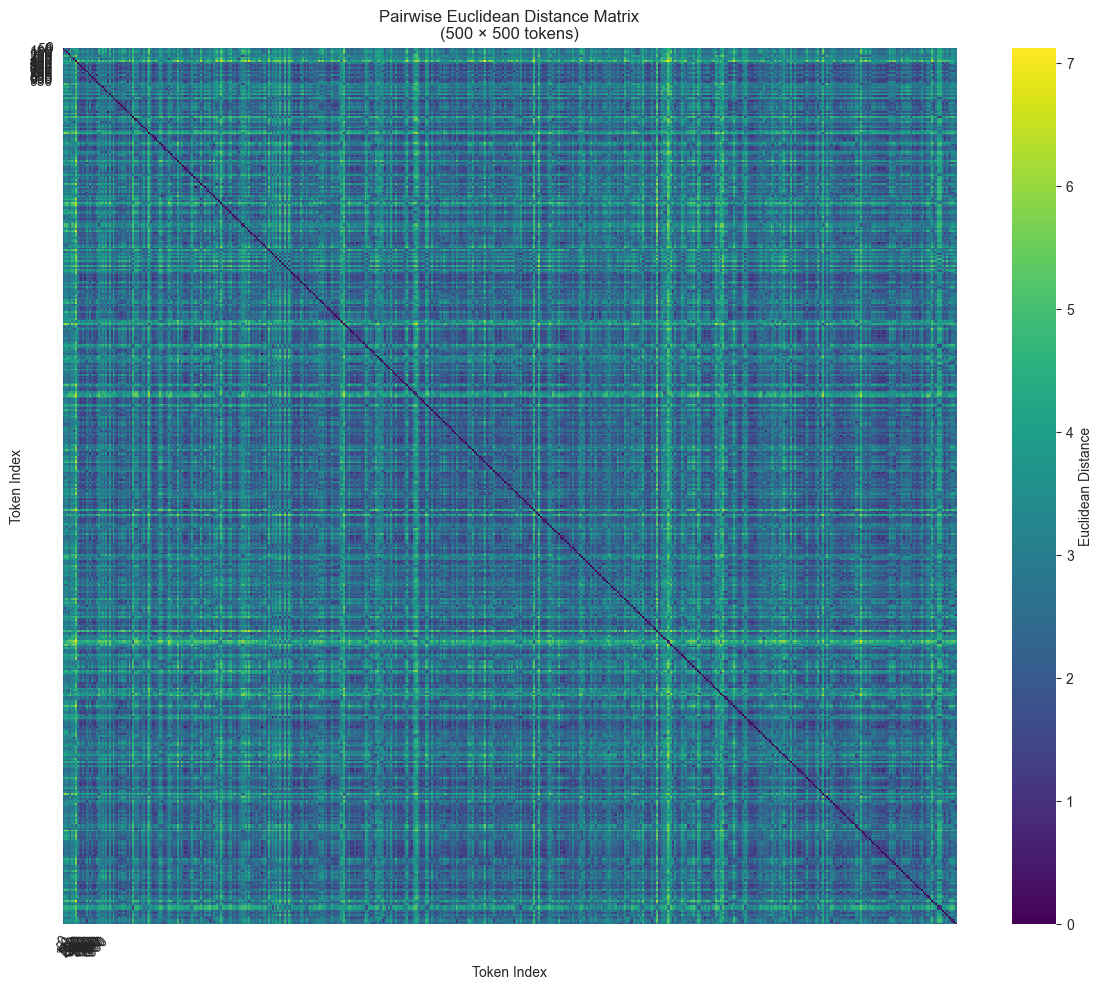

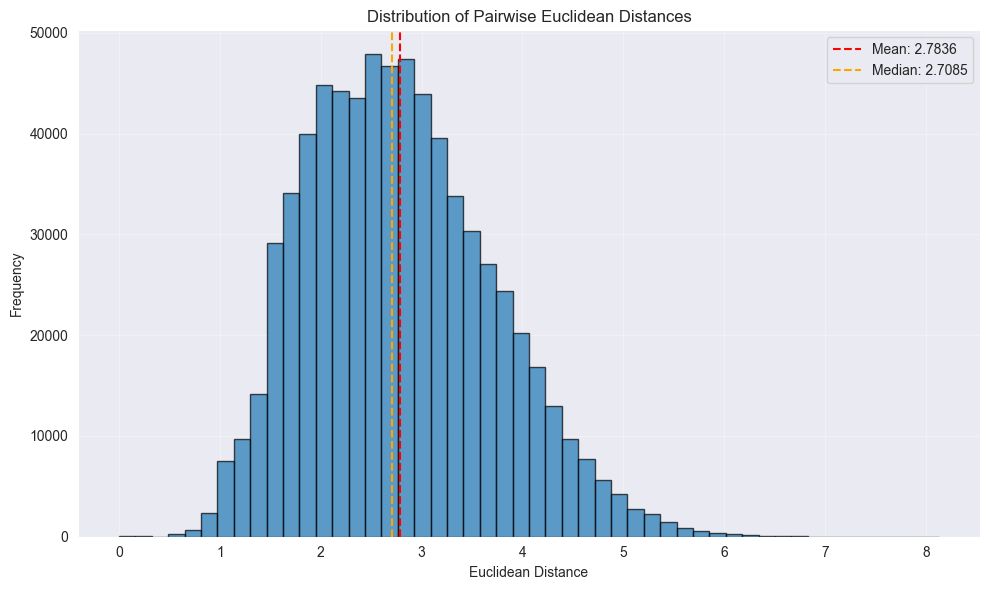

In [31]:
analyzer, distances, similar, different = analyze_embedding_distances('./embeddings_output/v1/performance/embeddings_performance1.npy')

Loaded embeddings: (1182, 1032)
Number of tokens: 1182
Embedding dimension: 1032
Calculating euclidean distance matrix...
Distance matrix shape: (1182, 1182)
Distance range: 0.000000 to 9.681178

PAIRWISE DISTANCE ANALYSIS SUMMARY
Distance metric: euclidean
Matrix size: 1182 × 1182
Total pairwise distances: 697971

Distance Statistics:
  Mean distance:   3.090292
  Median distance: 3.001485
  Std deviation:   0.966111
  Min distance:    0.000000
  Max distance:    9.681178
  25th percentile: 2.385690
  75th percentile: 3.701533

Most similar pairs (10):
 token_1  token_2     distance
      37       71 0.000000e+00
     410      499 4.712161e-08
     222      657 4.712161e-08
     657      847 4.712161e-08
     222      795 4.712161e-08
     795      847 4.712161e-08
     222      847 4.712161e-08
     657      795 4.712161e-08
     265      621 5.960464e-08
      50       72 1.135230e-06

Most different pairs (10):
 token_1  token_2  distance
     111      177  9.681178
     111      3

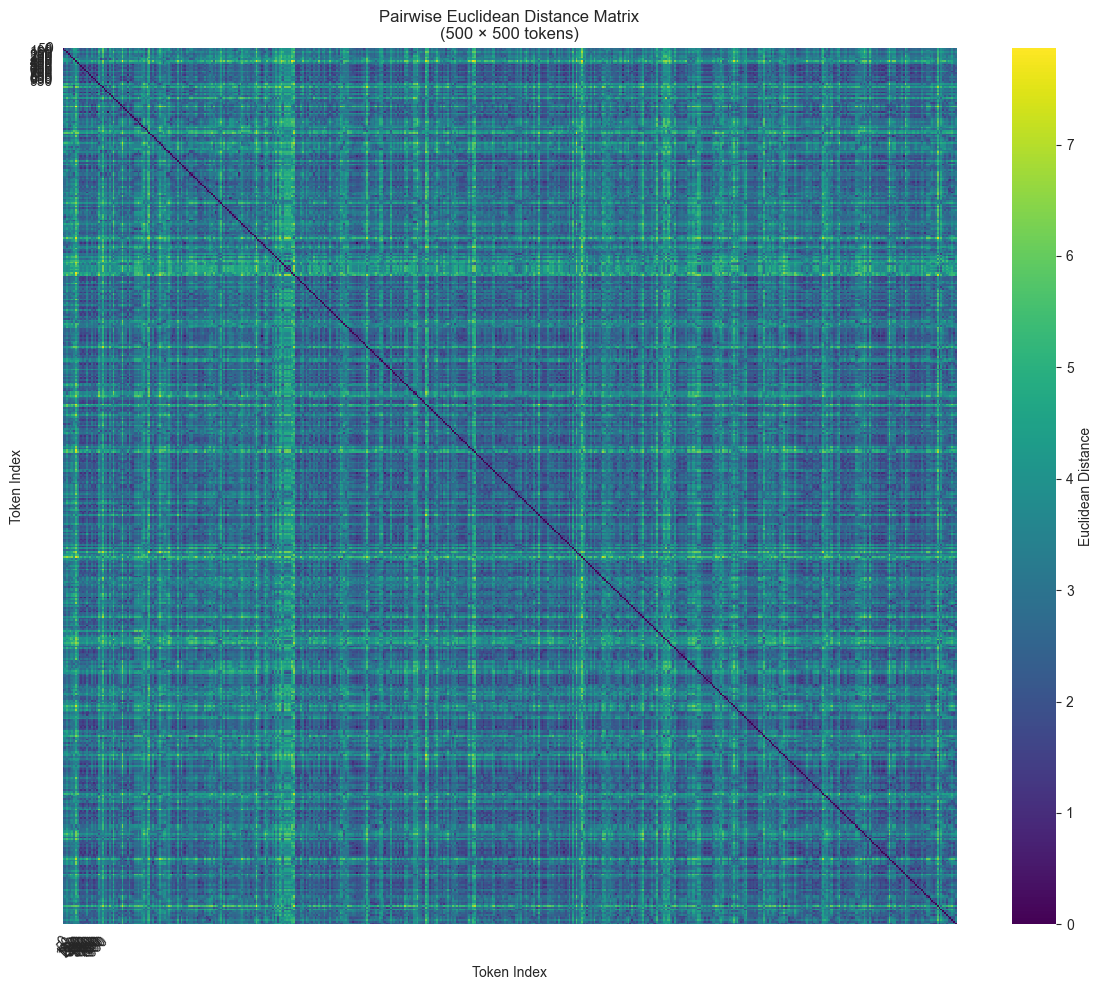

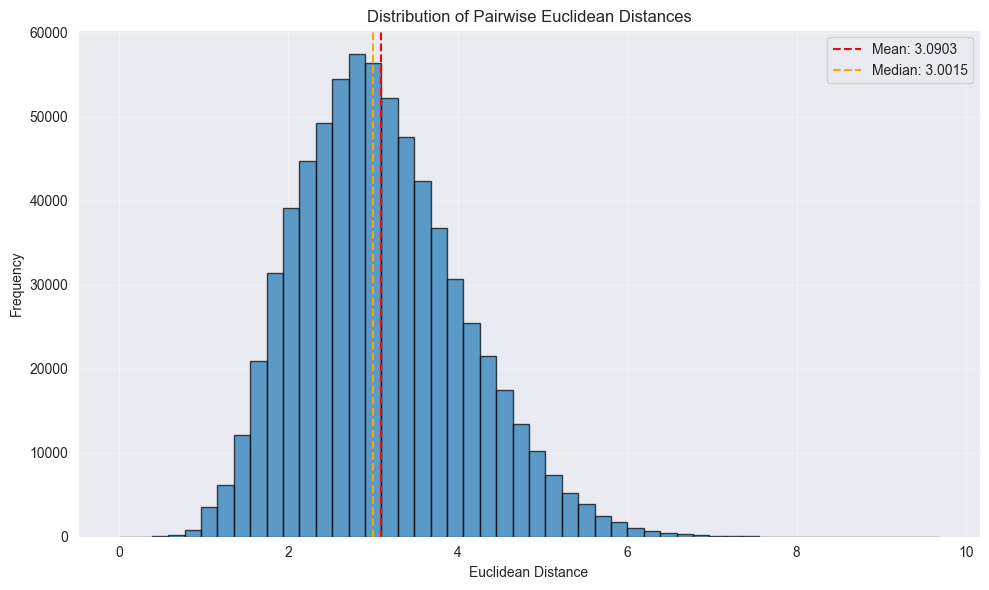

In [32]:
analyzer, distances, similar, different = analyze_embedding_distances('./embeddings_output/v2/performance/embeddings_performance1.npy')

Loaded embeddings: (1182, 1032)
Number of tokens: 1182
Embedding dimension: 1032
Calculating euclidean distance matrix...
Distance matrix shape: (1182, 1182)
Distance range: 0.000000 to 12.455556

PAIRWISE DISTANCE ANALYSIS SUMMARY
Distance metric: euclidean
Matrix size: 1182 × 1182
Total pairwise distances: 697971

Distance Statistics:
  Mean distance:   3.341958
  Median distance: 3.160476
  Std deviation:   1.262572
  Min distance:    0.000000
  Max distance:    12.455556
  25th percentile: 2.459402
  75th percentile: 3.987769

Most similar pairs (10):
 token_1  token_2     distance
    1040     1061 0.000000e+00
     847      912 0.000000e+00
     201      528 0.000000e+00
     940     1040 0.000000e+00
     940     1061 0.000000e+00
     361      739 3.650024e-08
     222      328 5.161914e-08
     122      328 5.161914e-08
     122      222 5.161914e-08
     462     1004 5.575504e-08

Most different pairs (10):
 token_1  token_2  distance
      41      723 12.455556
      41     

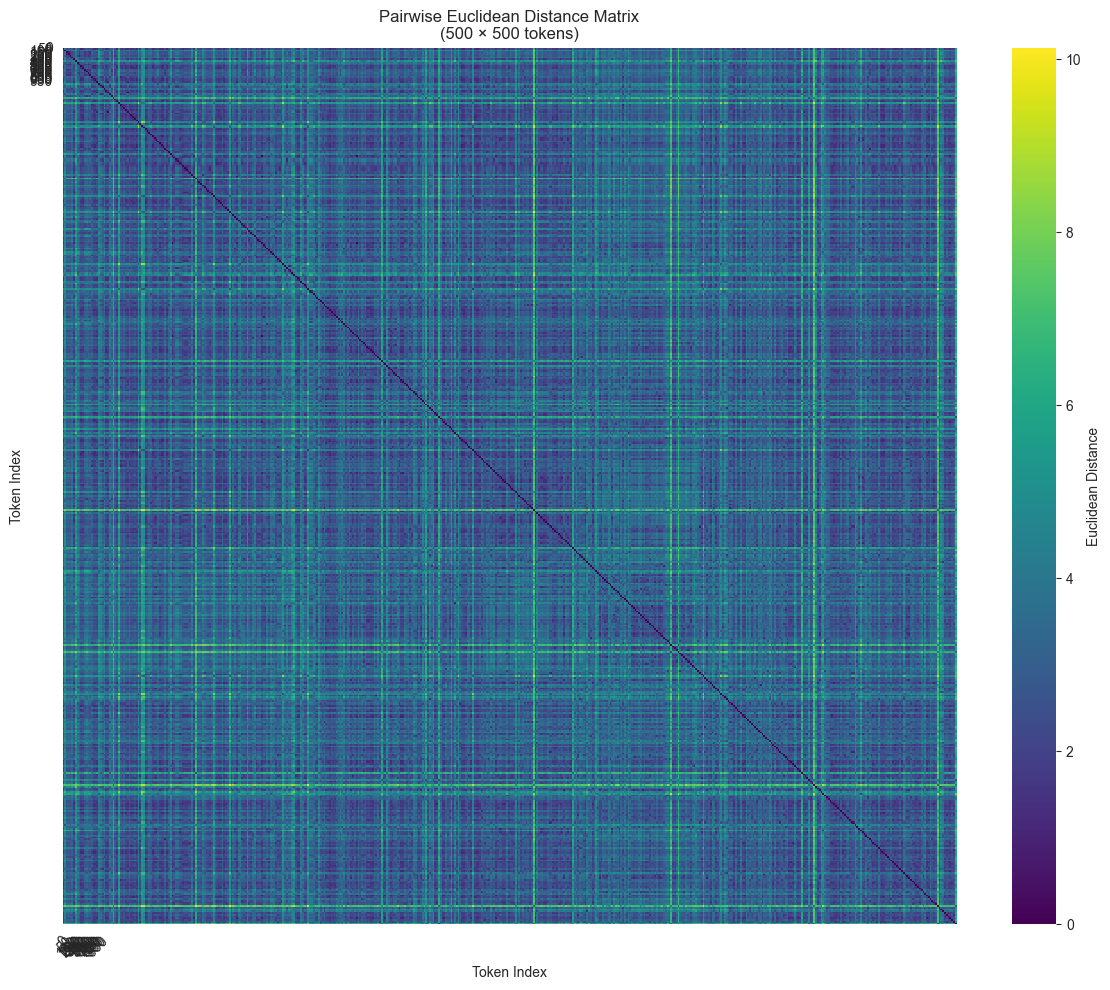

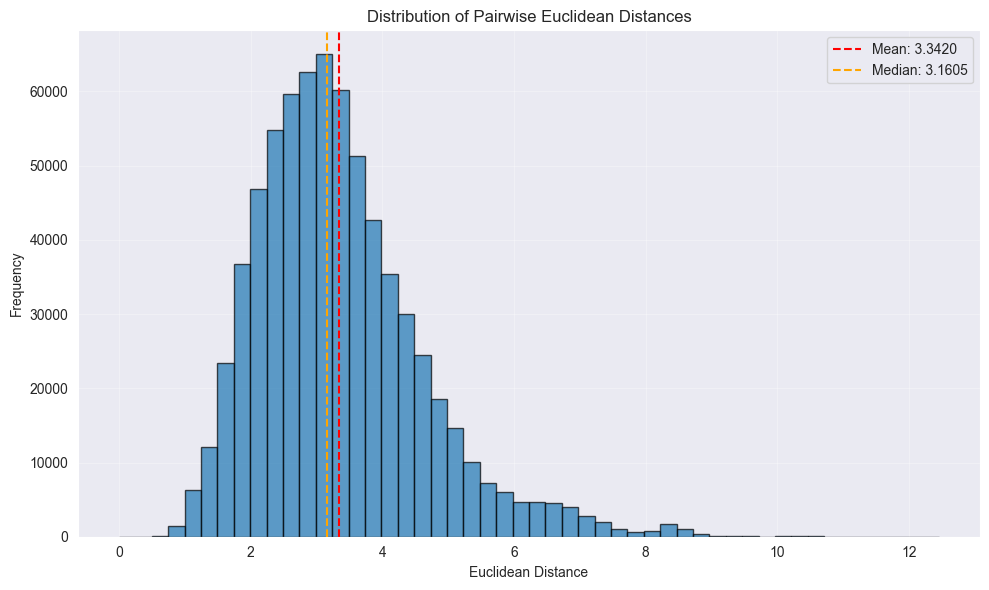

In [33]:
analyzer, distances, similar, different = analyze_embedding_distances('./embeddings_output/v3/performance/embeddings_performance1.npy')